<a href="https://colab.research.google.com/github/bmil-ssu/advanced_ann/blob/main/DDPG(TD3)_tutorial_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinfocrement learning 실습 #2
- Deep Deterministic Policy Gradeint (DDPG)
- Twin Delayed DDPG (TD3)
- 보완 필요사항
  - DDPG TD3 select action 구현
  - exploration noise 구현 + execution 시 exploitation하도록 변경 필오
  - 모델 성능 향상되는 hyperparameter search 조금 찾아볼 필요 있음
  - 마지막: reward model customizing 구현

In [1]:
# 필요한 module들 설치

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari, box2d] > /dev/null 2>&1
!sudo apt-get install xvfb
!pip install xvfbwrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 25 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [2]:
# 패키지 import
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random


from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

## DDPG, TD3 model 및 agent 정의

#### Actor model

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)) * self.max_action
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Critic model

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []

    def add(self, state, action, next_state, reward, done):
        self.buffer.append((state, action, next_state, reward, done))
        if len(self.buffer) > self.max_size:
            self.buffer.pop(0)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, next_state, reward, done = zip(*batch)
        return (
            torch.tensor(state, dtype=torch.float32).cuda(),
            torch.tensor(action, dtype=torch.float32).cuda(),
            torch.tensor(next_state, dtype=torch.float32).cuda(),
            torch.tensor(reward, dtype=torch.float32).cuda(),
            torch.tensor(done, dtype=torch.float32).cuda()
        )

#### DDPG agent

In [6]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).cuda()
        self.target_actor = Actor(state_dim, action_dim, max_action).cuda()
        self.critic = Critic(state_dim, action_dim).cuda()
        self.target_critic = Critic(state_dim, action_dim).cuda()
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)
        self.max_action = max_action

    def train(self, replay_buffer, batch_size, gamma, tau):
        state, action, next_state, reward, done = replay_buffer.sample(batch_size)

        # Update the critic
        target_Q = self.target_critic(next_state, self.target_actor(next_state))
        target_Q = reward + (1 - done) * gamma * target_Q
        current_Q = self.critic(state, action)
        critic_loss = F.mse_loss(current_Q, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update the actor
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update of target networks
        for param, target_param in zip(self.actor.parameters(), self.target_actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        return actor_loss.item(), critic_loss.item()

#### TD3 agent

In [7]:
class TD3Agent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).cuda()
        self.target_actor = Actor(state_dim, action_dim, max_action).cuda()
        self.critic = Critic(state_dim, action_dim).cuda()
        self.target_critic = Critic(state_dim, action_dim).cuda()
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)
        self.max_action = max_action

    def train(self, replay_buffer, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay):
        state, action, next_state, reward, done = replay_buffer.sample(batch_size)

        # Update the critic
        with torch.no_grad():
            noise = (torch.randn_like(action) * policy_noise).clamp(-noise_clip, noise_clip)
            next_action = (self.target_actor(next_state) + noise).clamp(-self.max_action, self.max_action)
            target_Q1 = self.target_critic(next_state, next_action)
            target_Q2 = self.target_critic(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (1 - done) * gamma * target_Q

        current_Q1 = self.critic(state, action)
        current_Q2 = self.critic(state, action)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy update
        if batch_size % policy_delay == 0:
            actor_loss = -self.critic(state, self.actor(state)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Soft update of target networks
            for param, target_param in zip(self.actor.parameters(), self.target_actor.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            return actor_loss.item(), critic_loss.item()
        else:
            return 0, critic_loss.item()

In [8]:
def train_agent(agent, replay_buffer, max_episodes, max_steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay):
    actor_losses = []
    critic_losses = []
    episode_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.actor(torch.tensor(state, dtype=torch.float32).cuda()).cpu().detach().numpy()
            action = np.clip(action, -env.action_space.high, env.action_space.high)

            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, next_state, reward, float(done))

            state = next_state
            total_reward += reward

            if len(replay_buffer.buffer) > batch_size:
                if isinstance(agent, DDPGAgent):
                    actor_loss, critic_loss = agent.train(replay_buffer, batch_size, gamma, tau)
                elif isinstance(agent, TD3Agent):
                    actor_loss, critic_loss = agent.train(replay_buffer, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay)
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)

            if done or step == max_steps - 1:
                episode_rewards.append(total_reward)
                print(f"Episode: {episode}, Total Reward: {total_reward}")
                break

    return actor_losses, critic_losses, episode_rewards

In [9]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [10]:
# Hyperparameters
max_episodes = 200
max_steps = 1000
batch_size = 64
gamma = 0.99
tau = 0.001
policy_noise = 0.2
noise_clip = 0.2
policy_delay = 2

In [11]:
ddpg_agent = DDPGAgent(state_dim, action_dim, max_action)
td3_agent = TD3Agent(state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer(max_size=100000)

In [12]:
ddpg_actor_losses, ddpg_critic_losses, ddpg_rewards = train_agent(ddpg_agent, replay_buffer, max_episodes, max_steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay)

<ipython-input-5-1eb2dd1367f2>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  torch.tensor(state, dtype=torch.float32).cuda(),
<ipython-input-6-3bb9d395818c>:20: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_Q, target_Q)


Episode: 0, Total Reward: -1250.6774814404114
Episode: 1, Total Reward: -1394.8536918558807
Episode: 2, Total Reward: -1676.7261475651471
Episode: 3, Total Reward: -1140.7879020730902
Episode: 4, Total Reward: -1441.3851541513386
Episode: 5, Total Reward: -1905.7602369259744
Episode: 6, Total Reward: -1367.7767358724473
Episode: 7, Total Reward: -1399.4546865775167
Episode: 8, Total Reward: -1462.4140191751371
Episode: 9, Total Reward: -1645.5640311151496
Episode: 10, Total Reward: -1450.8411321276726
Episode: 11, Total Reward: -1875.8653400459184
Episode: 12, Total Reward: -1620.9592617589235
Episode: 13, Total Reward: -1479.7340409411809
Episode: 14, Total Reward: -1822.5077547666197
Episode: 15, Total Reward: -1819.3118485198693
Episode: 16, Total Reward: -1339.1107753175295
Episode: 17, Total Reward: -1441.559352902555
Episode: 18, Total Reward: -1526.9170791628042
Episode: 19, Total Reward: -1302.2414756937108
Episode: 20, Total Reward: -1394.061463446633
Episode: 21, Total Reward

In [13]:
td3_actor_losses, td3_critic_losses, td3_rewards = train_agent(td3_agent, replay_buffer, max_episodes, max_steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay)

<ipython-input-7-27c11aee756b>:27: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)


Episode: 0, Total Reward: -1569.7266048068473
Episode: 1, Total Reward: -987.6678829008375
Episode: 2, Total Reward: -1422.704256361331
Episode: 3, Total Reward: -1324.179787838218
Episode: 4, Total Reward: -1772.135875879874
Episode: 5, Total Reward: -1500.8811480622417
Episode: 6, Total Reward: -1785.1097451345017
Episode: 7, Total Reward: -1880.124570391711
Episode: 8, Total Reward: -1208.0981736596905
Episode: 9, Total Reward: -1839.8737436496044
Episode: 10, Total Reward: -1772.94701249247
Episode: 11, Total Reward: -1345.659237785848
Episode: 12, Total Reward: -1357.8259076034128
Episode: 13, Total Reward: -1809.1055385487068
Episode: 14, Total Reward: -1087.4452249451974
Episode: 15, Total Reward: -1344.2580606733493
Episode: 16, Total Reward: -985.886970778011
Episode: 17, Total Reward: -1237.832505248888
Episode: 18, Total Reward: -1655.5901104600139
Episode: 19, Total Reward: -1328.5564439563068
Episode: 20, Total Reward: -1373.8847643753816
Episode: 21, Total Reward: -1379.6

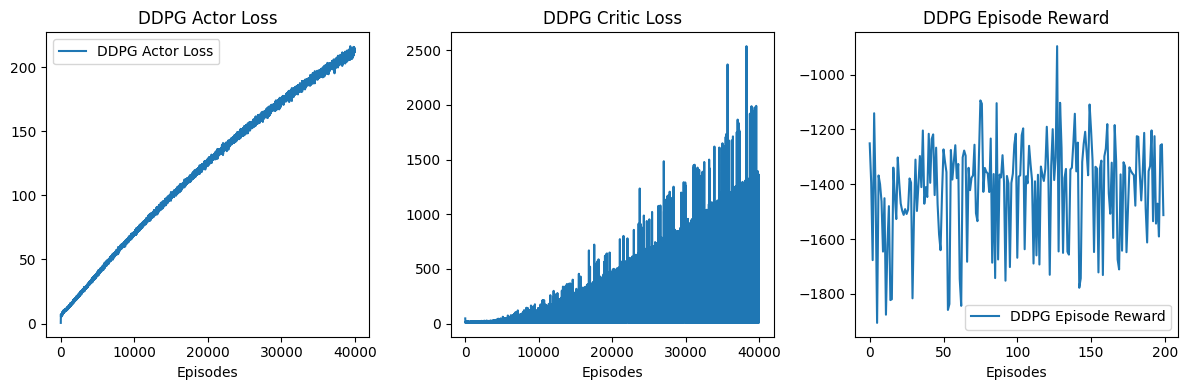

In [14]:
# Plot the results

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(ddpg_actor_losses, label='DDPG Actor Loss')
plt.title('DDPG Actor Loss')
plt.xlabel('Episodes')
plt.legend()

plt.subplot(132)
plt.plot(ddpg_critic_losses, label='DDPG Critic Loss')
plt.title('DDPG Critic Loss')
plt.xlabel('Episodes')

plt.subplot(133)
plt.plot(ddpg_rewards, label='DDPG Episode Reward')
plt.title('DDPG Episode Reward')
plt.xlabel('Episodes')
plt.legend()

plt.tight_layout()
plt.show()

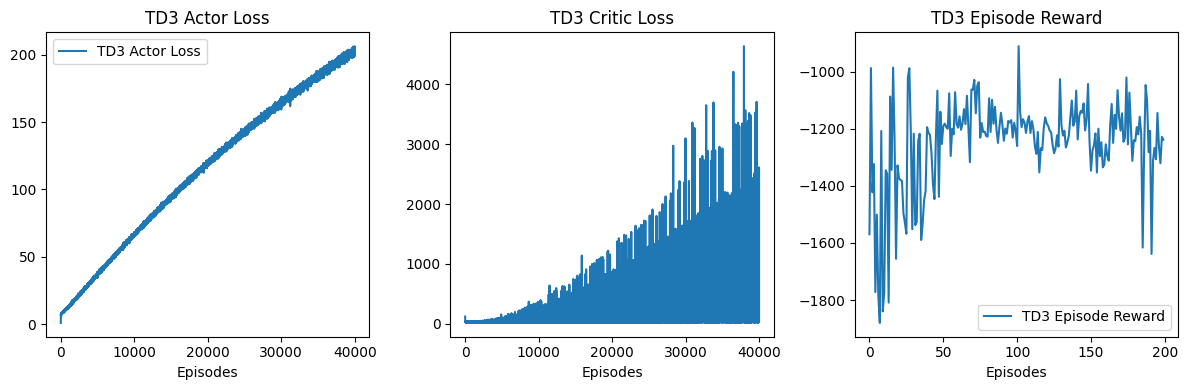

In [15]:
# Plot the results

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(td3_actor_losses, label='TD3 Actor Loss')
plt.title('TD3 Actor Loss')
plt.xlabel('Episodes')
plt.legend()

plt.subplot(132)
plt.plot(td3_critic_losses, label='TD3 Critic Loss')
plt.title('TD3 Critic Loss')
plt.xlabel('Episodes')

plt.subplot(133)
plt.plot(td3_rewards, label='TD3 Episode Reward')
plt.title('TD3 Episode Reward')
plt.xlabel('Episodes')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# # Plot losses and rewards
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(actor

In [17]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [18]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [19]:
def eval_w_video(env, agent):
    display = Display(visible=0, size=(1400, 900))
    display.start()
    eval_env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
    state = eval_env.reset()
    eval_reward = 0
    while True:
      eval_env.render()

      action = agent.actor(torch.tensor(state, dtype=torch.float32).cuda()).cpu().detach().numpy()
      action = np.clip(action, -eval_env.action_space.high, eval_env.action_space.high)
      next_state, reward, done, _ = eval_env.step(action)

      state = next_state
      eval_reward+= reward
      if done:
        break;

    eval_env.close()
    show_video()
    print('reward', eval_reward)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
eval_w_video(env, ddpg_agent)

reward -1230.518151388171


In [21]:
eval_w_video(env, td3_agent)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reward -1353.2689783814694


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
